# The R Programming Language

1. **R**: Popular **open-source programming language** for statistical analysis
2. Widely used in statistics and econometrics
3. **User-friendly and powerful IDE**: [RStudio](https://www.rstudio.com/)
4. Basic functionalities of **R** can be extended by **packages**
5. Large number of packages available on the 
[Comprehensive R Archive Network](https://cran.r-project.org/) (CRAN)
6. **Goal of this presentation:** Illustrate how to use `R` for the estimation of a
Poisson regression model

In [1]:
# install.packages("psych")
# install.packages("wooldridge")
# install.packages("xtable") 

## Count data models

**Count data** models are used to explain dependent variables that are natural 
numbers, i.e., positive integers such that $y_i \in \mathbb{N}$, where 
$\mathbb{N} = \{0, 1, 2,\ldots\}$. 

Count data models are frequently used in economics to study **countable events**:
Number of years of education, number of patent applications filed by companies, 
number of doctor visits, number of crimes committed in a given city, etc. 

The **Poisson model** is a popular count data model.

## Poisson regression model

Given a parameter $\lambda_i > 0$, the **Poisson model** assumes that the 
probability of observing $Y_i=y_i$, where $y_i\in\mathbb{N}$, is equal to:
$$Prob(Y_i = y_i \mid \lambda_i) = \frac{\lambda_i^{y_i}\exp\{-\lambda_i\}}{y_i!},$$
for $i=1,\ldots,N$.

The mean and the variance of $Y_i$ are equal to the parameter $\lambda_i$:  
$$E(Y_i\mid\lambda_i) = V(Y_i\mid\lambda_i) = \lambda_i,$$
implying *equi-dispersion* of the data.

To control for **observed characteristics**, the parameter $\lambda_i$ can be 
parametrized as follows (implying $\lambda_i > 0$):
$$E(Y_i|X_i,\beta) \equiv \lambda_i = \exp\{X_i'\beta\},$$
where $X_i$ is a vector containing the covariates.

## Simulating data

`R` function simulating data from Poisson regression model:

In [2]:
simul_poisson <- function(n, beta) {
  k <- length(beta)               # number of covariates
  x <- replicate(k - 1, rnorm(n)) # simulate covariates
  x <- cbind(1, x)                # for intercept term
  lambda <- exp(x %*% beta)       # individual means
  y <- rpois(n, lambda)           # simulate count
  return(data.frame(y, x))        # return variables
}

Using function to generate data:

In [3]:
set.seed(123)
nobs <- 1000
beta <- c(-.5, .4, -.7)
data <- simul_poisson(nobs, beta)

## Data description

Descriptive statistics:

In [4]:
# extract variables of interest from data set
y <- data[, 1]
x <- as.matrix(data[, 2:4])

# descriptive statistics
library(psych)
describe(data)

Warning message:
"package 'psych' was built under R version 3.6.3"

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
y,1,1000,0.75600000,1.081496,0.000000000,0.542500000,0.0000000,0.000000,8.000000,8.000000,2.0410562,5.92292208,0.03419991
X1,2,1000,1.00000000,0.000000,1.000000000,1.000000000,0.0000000,1.000000,1.000000,0.000000,NaN,NaN,0.00000000
X2,3,1000,0.01612787,0.991695,0.009209639,0.008963342,0.9641412,-2.809775,3.241040,6.050815,0.0651960,-0.08010201,0.03136015
X3,4,1000,0.04246525,1.009674,0.054852377,0.048416669,1.0469486,-3.047861,3.390371,6.438232,-0.0105134,-0.07188844,0.03192870


## Data Description

Histogram of count variable:

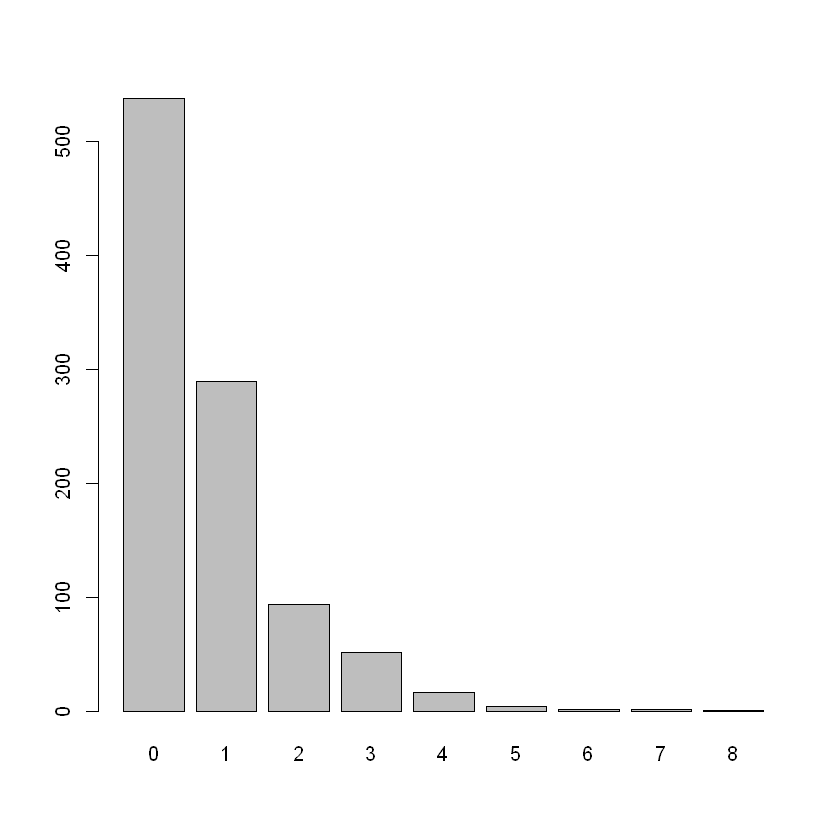

In [5]:
barplot(table(y))

## Data Description

Relationship between count variable and covariates:

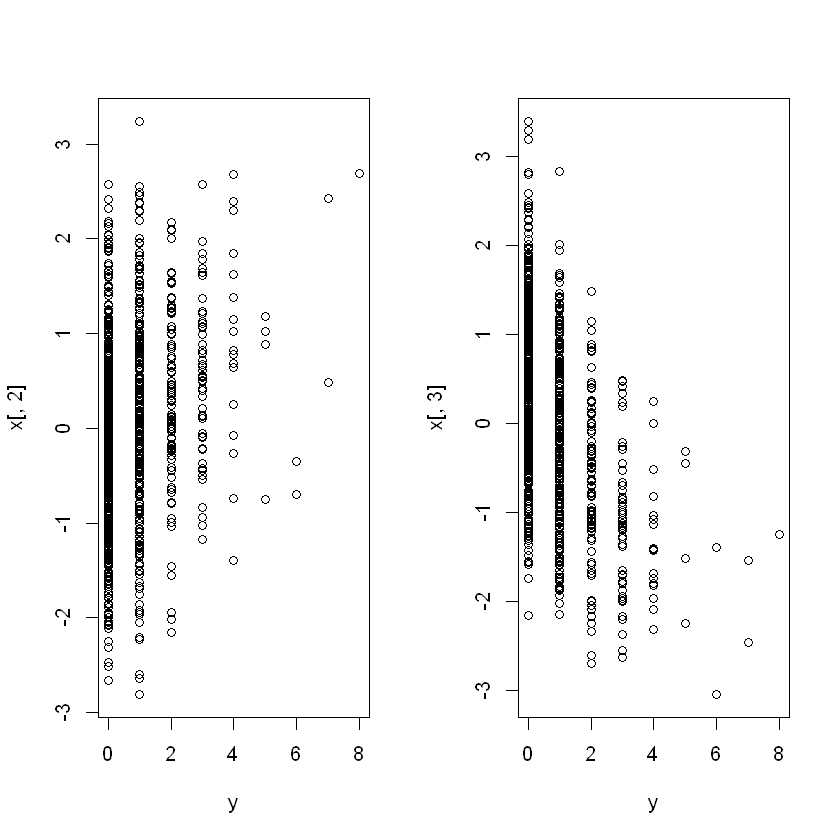

In [6]:
par(mfrow = c(1, 2))
plot(y, x[, 2])
plot(y, x[, 3])

## Likelihood Function and ML Estimator

Individual contribution to the likelihood function:
$$L_i(\beta;y_i,x_i) = \frac{\exp\{y_ix_i\beta\}\exp\{-\exp\{x_i\beta\}\}}{y_i!}$$
Individual log-Likelihood function:
$$\ell_i(\beta;y_i,x_i) = \log L_i(\beta;y_i,x_i) 
= y_ix_i\beta - \exp\{x_i\beta\} - \log(y_i!)$$

Maximum Likelihood Estimator:
$$\hat{\beta}_{\text{MLE}} = \arg\max_{\beta} \sum_{i=1}^N \ell(\beta;y,X)$$

Optimization (using *minimization* of objective function): 
$$\hat{\beta}_{\text{MLE}} = \arg\min_{\beta} Q(\beta;y,X) \qquad
Q(\beta;y,X) = -\frac{1}{N}\sum_{i=1}^N \ell_i(\beta;y_i,x_i)$$

## Coding the Objective Function

In [7]:
# Objective function of Poisson regression model
obj_poisson <- function(beta, y, x) {
  lambda <- x %*% beta
  llik <- y*lambda - exp(lambda) - lfactorial(y)
  return(-mean(llik))
}

# Evaluating objective function
beta0 <- c(1, 2, 3)
obj_poisson(beta0, y, x)

[1] 1757.113

## Maximizing the Objective Function

Set starting values:

In [8]:
beta0 <- rep(0, length(beta))

Optimize using quasi-Newton method (BFGS algorithm):

In [9]:
opt <- optim(beta0, obj_poisson, method = "BFGS", 
             y = y, x = x)

Show results:

In [10]:
cat("ML estimates:", opt$par,
    "\nObjective function:", opt$value, "\n")

ML estimates: -0.5740286 0.3921569 -0.7231029 
Objective function: 0.9998689 


## Comparing Results to Built-in Function

In [11]:
opt_glm <- glm(y ~ 0 + x, family = poisson)
summary(opt_glm)


Call:
glm(formula = y ~ 0 + x, family = poisson)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.1707  -0.9185  -0.5915   0.5133   3.6768  

Coefficients:
    Estimate Std. Error z value Pr(>|z|)    
xX1 -0.57403    0.04602  -12.47   <2e-16 ***
xX2  0.39216    0.03690   10.63   <2e-16 ***
xX3 -0.72310    0.03662  -19.74   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 1475.06  on 1000  degrees of freedom
Residual deviance:  930.17  on  997  degrees of freedom
AIC: 2005.7

Number of Fisher Scoring iterations: 5


## Comparing Results to Built-in Function

Collect results from the two approaches to compare them:

In [12]:
res <- cbind("True" = beta, "MLE" = opt$par, 
             "GLM" = opt_glm$coefficients)
row.names(res) <- c("constant", "x1", "x2")
res

,True,MLE,GLM
constant,-0.5,-0.5740286,-0.5740289
x1,0.4,0.3921569,0.3921561
x2,-0.7,-0.7231029,-0.7231039


**Question:** Our results (`MLE`) are virtually the same as those obtained 
with the built-in function `GLM`, but not identical. Where do the small 
differences come from?

## Empirical Illustration

**Goal:** Investigate the determinants of fertility.

Poisson regression model used to estimate the relationship between explanatory
variables and count outcome variable.

Both our estimator coded from scratch and `R` built-in function will be used.

## Data

**Source:** Botswana's 1988 Demographic and Health Survey.

Data set borrowed from Wooldridge:

In [13]:
library(wooldridge)
data(fertil2)

Warning message:
"package 'wooldridge' was built under R version 3.6.3"

Outcome variable: Total number of living children:

In [14]:
y_lab <- "children"

Explanatory variables: Education, age, marital status, living in urban area,
having electricity/TV at home:

In [15]:
x_lab <- c("educ", "age", "agesq", "evermarr", "urban", 
           "electric", "tv")

## Loading data

Selecting variables and removing missing values:

In [16]:
data <- fertil2[, c(y_lab, x_lab)]
data <- na.omit(data)

Show first 6 observations on first 8 variables:

In [17]:
head(data[, 1:8], n = 6)

children,educ,age,agesq,evermarr,urban,electric,tv
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0,12,24,576,0,1,1,1
3,13,32,1024,1,1,1,1
1,5,30,900,1,1,1,0
2,4,42,1764,1,1,1,1
2,11,43,1849,1,1,1,1
1,7,36,1296,1,1,1,0


## Descriptive Statitics

In [18]:
library(psych)
describe(data)

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
children,1,4358,2.26755392,2.2219115,2,1.95355505,2.9652,0,13,13,1.07461443,0.7535459,0.033657599
educ,2,4358,5.85612666,3.9268849,7,5.79271789,4.4478,0,20,20,-0.02676386,-0.4977637,0.059484602
age,3,4358,27.40431391,8.6858782,26,26.71014908,8.8956,15,49,34,0.59127861,-0.4947282,0.131574013
agesq,4,4358,826.42358880,526.9622499,676,752.86897936,467.0190,225,2401,2176,1.10025766,0.5186238,7.982444206
evermarr,5,4358,0.47636531,0.4994984,0,0.47047018,0.0000,0,1,1,0.09461200,-1.9915054,0.007566421
urban,6,4358,0.51652134,0.4997843,1,0.52064220,0.0000,0,1,1,-0.06609871,-1.9960888,0.007570752
electric,7,4358,0.14020193,0.3472363,0,0.05045872,0.0000,0,1,1,2.07187764,2.2932033,0.005259948
tv,8,4358,0.09293254,0.2903712,0,0.00000000,0.0000,0,1,1,2.80312970,5.8588807,0.004398554


## Plot

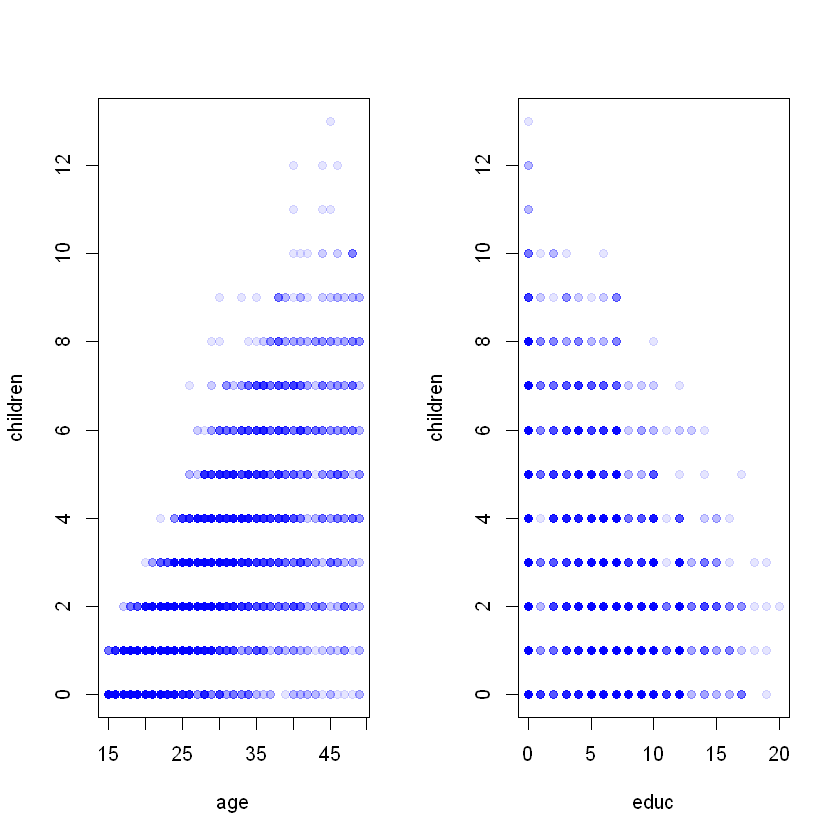

In [19]:
attach(data)
par(mfrow = c(1, 2))
blue_transp <- adjustcolor("blue", alpha.f = 0.1)
plot(age, children, pch = 19, col = blue_transp)
plot(educ, children, pch = 19, col = blue_transp)

## MLE of the Poisson Model

Maximum likelihood function using built-in function `glm()`:

In [20]:
mle <- glm(children ~ educ + age + agesq + evermarr + 
             urban + electric + tv,
           family = "poisson", data = data)

Maximum likelihood function using our own function:

In [21]:
y <- data[, y_lab]
x <- as.matrix(data[, x_lab])
x <- cbind(1, x)          # for intercept term
beta0 <- rep(0, ncol(x))  # starting values
opt <- optim(beta0, obj_poisson, method = "BFGS", 
             y = y, x = x)

## MLE of the Poisson Model

**Results different from `glm()`?**

Optimization algorithms are iterative methods that rely on different criteria
to dertermine if/when the optimum has been reached.

**For example:** Change in the objective function, change in the parameter values,
change in the gradient, step size, etc.

*[More in Advanced Microeconometrics course].*

**Try to adjust tuning parameters**, for example add 
`control = list(ndeps = rep(1e-8, ncol(x)))` to `optim()` to change step size 
of gradient approximation.

## Summarizing the Empirical Results

In [22]:
summary(mle)


Call:
glm(formula = children ~ educ + age + agesq + evermarr + urban + 
    electric + tv, family = "poisson", data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.5620  -0.8116  -0.1091   0.5439   2.8893  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -5.3748294  0.1628671 -33.001  < 2e-16 ***
educ        -0.0216645  0.0029131  -7.437 1.03e-13 ***
age          0.3373308  0.0099365  33.949  < 2e-16 ***
agesq       -0.0041158  0.0001453 -28.331  < 2e-16 ***
evermarr     0.3147510  0.0244473  12.875  < 2e-16 ***
urban       -0.0860549  0.0216487  -3.975 7.04e-05 ***
electric    -0.1205347  0.0388390  -3.103  0.00191 ** 
tv          -0.1447046  0.0473875  -3.054  0.00226 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 10076.1  on 4357  degrees of freedom
Residual deviance:  3908.8  on 4350  degrees of freedom
AIC: 13010

Nu

## Fitted Values

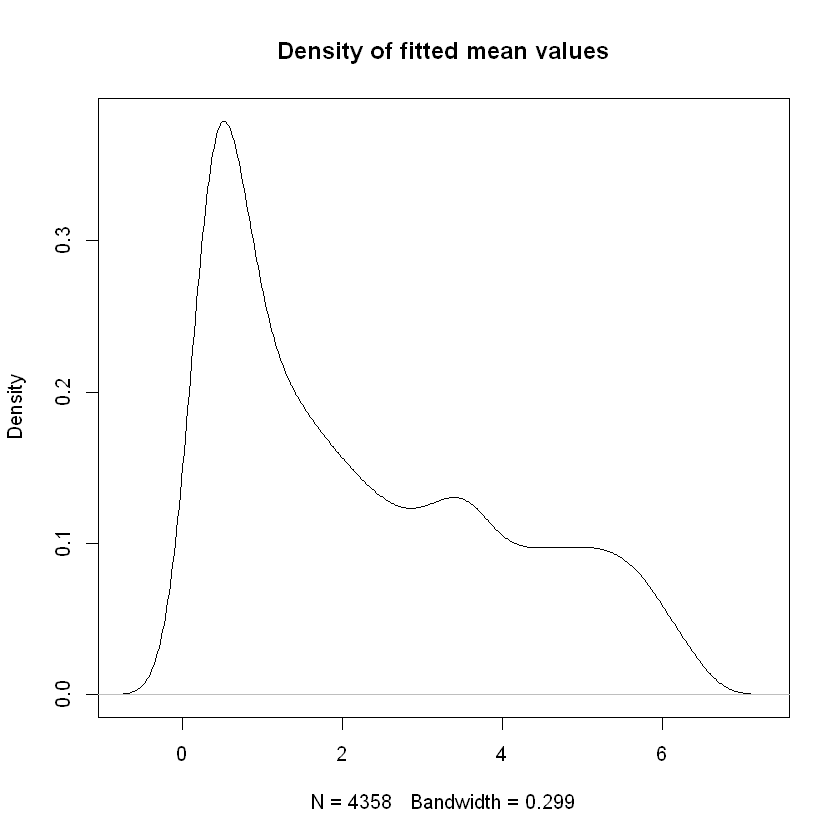

In [23]:
plot(density(mle$fitted.values), 
     main = "Density of fitted mean values")

## Formatting the results

In [24]:
library(xtable)
xtable(mle)

Warning message:
"package 'xtable' was built under R version 3.6.3"

,Estimate,Std. Error,z value,Pr(>|z|)
,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-5.374829404,0.1628671333,-33.001314,7.777386e-239
educ,-0.021664469,0.0029131037,-7.436903,1.030735e-13
age,0.337330821,0.0099365076,33.948630,1.277867e-252
agesq,-0.004115829,0.0001452774,-28.330823,1.442293e-176
evermarr,0.314751037,0.0244472864,12.874682,6.249598e-38
urban,-0.086054903,0.0216486641,-3.975068,7.035927e-05
electric,-0.120534717,0.0388390189,-3.103444,1.912825e-03
tv,-0.144704596,0.0473875108,-3.053644,2.260801e-03
